# Equifinality Testing

Something that might add a lot of noise to coefficient estimation is equifinality in site-specific models. This Notebook analyzes the actual impact of such equifinality.

The basic procedure for a given watershed:

- Fit a calibrated model to the full timeseries. (We're interested in equally-performant coefficient sets, not in cal/val uncertainty, so we don't use a validation period.)
- Evaluate performance.
- Now, generate N random parameter sets, uniformly distributed. See which have less than an x% RMSE penalty and identify a behavioral envelope (think GLUE).
- Analyze distributions.

The immediate result, for $G$ gages and $p$ parameters, is a $(G\cdot N)\times p$ matrix of parameter sets mapped to a vector of $G\cdot N$ percentage RMSE penalties and a matrix of $G\times p$ original (fitted) parameter sets. This can be analyzed in a variety of ways; two major ones come to mind:

- 1:1 plots showing whether the behavioral envelope varies with the value of the coefficient.
- Histograms of "coefficient elasticity of RMSE" by site, identifying how variable the sensitivity is.

Another interesting question will be whether any parameter sets actually have a *negative* penalty, i.e., outperform the fitted coefficient set. (This is a distinct behavior from a, strictly speaking, calibrated model, since our site parameters aren't actually calibrated but rather explicitly computed from the data.)

For this test, we disable the anomaly GAM because setting it up for the randomized models would be logistically annoying.

# Setup

In [41]:
import NEWT
from rtseason import ThreeSine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import os
import scipy
from scipy.stats.qmc import LatinHypercube
sns.set_context("paper")
bp = "/scratch/dphilippus/notebooks/next_validation/"

In [2]:
dev_data = pd.read_csv(bp + "DevDataBuffers.csv", dtype={"id": "str"}, parse_dates=["date"])[
    ["id", "date", "day", "temperature", "tmax"]
]
dev_data = dev_data.loc[(dev_data["temperature"] > -0.5) & (dev_data["temperature"] < 40)]

# Reference Performance

In [3]:
def perf_wcoef(site):
    model = NEWT.Watershed.from_data(site, use_anomgam=False)
    if model is None:
        return None
    pred = model.run_series(site)
    perf = NEWT.analysis.perf_summary(pred)["RMSE"]
    coefs = model.coefs_to_df().drop(columns=["R2", "RMSE"])
    print("|", end="")
    return pd.concat([coefs, perf], axis=1)

In [4]:
with warnings.catch_warnings(action="ignore"):
    reference = dev_data.groupby("id").apply(perf_wcoef, include_groups=False).droplevel(1)

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [5]:
reference

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,at_coef,RMSE
id,,,,,,,,,,
01010000,8.227527,11.664508,323.0,27.5,120.0,236.0,1.989669,3.269881,0.313388,1.819758
01011000,8.547659,11.735706,322.0,27.0,120.0,204.0,2.563314,2.746746,0.271996,1.510067
01018035,9.074948,12.007753,321.0,28.0,120.0,206.0,1.838306,2.569034,0.364230,1.560736
01038000,10.871231,12.433309,319.0,27.0,169.0,200.0,0.899632,1.966065,0.380036,1.318067
010642505,8.232986,9.252760,321.0,26.0,122.0,233.0,1.766506,1.030557,0.333147,1.141534
...,...,...,...,...,...,...,...,...,...,...
385903107210800,7.163091,9.258731,300.0,87.0,143.0,201.0,2.083604,1.409694,0.375744,1.682636
394220106431500,6.965011,7.357272,324.0,84.0,156.0,237.0,2.823831,1.979052,0.257349,1.281264
402114105350101,4.352286,7.339022,301.0,88.0,153.0,237.0,2.495065,0.984321,0.329488,1.207342


# Randomized Parameters

We'll just generate one set of 10,000 for all sites, just to make things simple. Each parameter is allowed to be anywhere in the observed range (above).

## Generate Samples

In [46]:
rawmat = pd.DataFrame(LatinHypercube(9).random(n=10000), columns=reference.columns[:9])

In [47]:
mins = reference[rawmat.columns].min()
maxes = reference[rawmat.columns].max()
ranges = maxes - mins
rpar = rawmat * ranges + mins

In [48]:
rpar

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,at_coef
0,4.392190,3.314676,319.789473,47.088833,168.259923,232.966982,-1.133300,2.580337,0.134512
1,13.099745,4.413748,306.072873,32.831458,161.304164,211.589182,-1.441863,3.828948,0.704414
2,29.502348,14.047415,356.095264,62.119325,174.787572,200.956265,4.388531,1.691927,-0.083298
3,15.259363,8.398897,364.510366,5.631580,158.816702,228.509785,4.091823,3.998571,0.498268
4,22.557632,9.428832,332.113289,51.770654,153.003713,216.329482,-0.568407,3.747276,0.348681
...,...,...,...,...,...,...,...,...,...
9995,4.813997,11.965730,314.308220,10.544395,171.164461,221.752723,4.484773,-1.641342,0.312446
9996,18.646251,12.401228,332.525996,9.436075,126.608671,202.615849,2.451570,-0.440089,-0.117877
9997,8.060620,8.084589,312.828469,106.069546,144.233106,215.720401,2.011957,-0.190503,0.450565
9998,7.918623,14.244823,360.014470,76.322819,173.570892,226.488237,0.695524,4.302813,0.817570


## Compute Performance

To avoid an excessively large result, for each site, we only keep the 1000 rows with the best performance. This will result in approx. 1M rows total, instead of the unmanageable 10M resulting from storing everything.

The first site, with 10k iterations, took about 200 seconds, or 0.02 seconds per run. That's fast individually, but too many to be manageable in a Jupyter notebook. This Notebook has been converted to Python and is running in the background.

In [9]:
def random_perf(params=rpar):
    def inner(site):
        daily = site.groupby(["day"], as_index=False)["tmax"].mean().rename(columns={"tmax": "mean_tmax"})
        pser = pd.Series([
            NEWT.analysis.perf_summary(
                NEWT.Watershed(
                    seasonality=ThreeSine(
                        Intercept=prow.Intercept,
                        Amplitude=prow.Amplitude,
                        SpringSummer=prow.SpringSummer,
                        FallWinter=prow.FallWinter,
                        SpringDay=prow.SpringDay,
                        SummerDay=prow.SummerDay,
                        FallDay=prow.FallDay,
                        WinterDay=prow.WinterDay
                    ),
                    at_coef=prow.at_coef,
                    at_day=daily
                ).run_series(site)
            )["RMSE"].iloc[0]
            for prow in params.itertuples()
        ]).rename("RMSE")
        print("|", end="")
        return pd.concat([params, pser], axis=1).sort_values("RMSE").head(1000)
    return inner

In [52]:
outfile = bp + "results/EquifinalMatrix.csv"
rerun = False
if os.path.exists(outfile) and not rerun:
    rpdata = pd.read_csv(outfile, dtype={"id": "str"}, index_col=[0, 1])
else:
    with warnings.catch_warnings(action="ignore"):
        start = time.time()
        rpdata = dev_data.loc[dev_data["id"].isin(reference.index)
                             ].groupby("id").apply(random_perf(), include_groups=False)
        print(f"Runtime: {(time.time() - start)/60: .02f} minutes for {len(rpar)} iterations over {len(reference)} sites")
        rpdata.to_csv(outfile)

## Analyze Performance

In [62]:
delta = (rpdata - reference)
delta["RMSE"] = delta["RMSE"] / reference["RMSE"] * 100

In [72]:
threshold = 10  # RMSE %change threshold
behav = delta.loc[delta["RMSE"] < threshold].melt("RMSE", ignore_index=False)
reflong = reference.drop(columns=["RMSE"]).melt(ignore_index=False).rename(columns={"value": "ref_value"})
comb = behav.merge(reflong, on=["id", "variable"])
comb

,RMSE,variable,value,ref_value
id,,,,
01011000,-4.925340,Intercept,-2.720799,8.547659
01011000,3.589314,Intercept,-1.038332,8.547659
01011000,6.196358,Intercept,-2.304612,8.547659
015765195,9.867959,Intercept,-0.235479,12.246304
02169000,1.274219,Intercept,0.630983,15.122052
...,...,...,...,...
07075250,7.547695,at_coef,-0.439210,0.425834
07075250,7.567439,at_coef,0.338088,0.425834
07075250,8.349269,at_coef,0.329334,0.425834


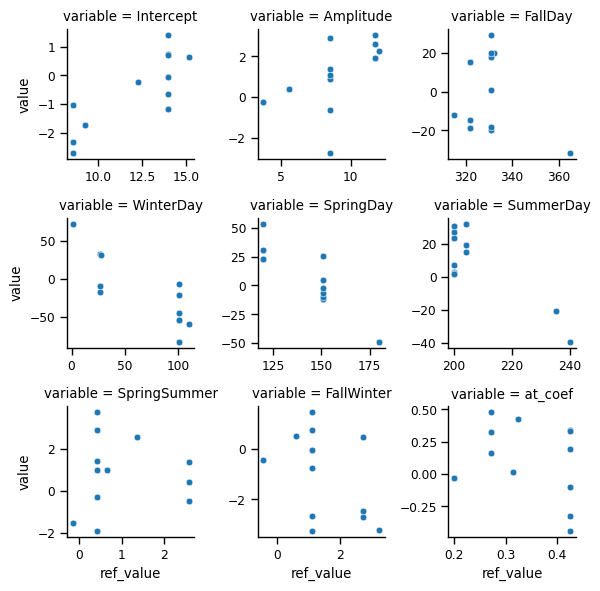

In [79]:
sns.relplot(comb, x="ref_value", y="value", col="variable", col_wrap=3,
           height=2, facet_kws={"sharex": False, "sharey": False})

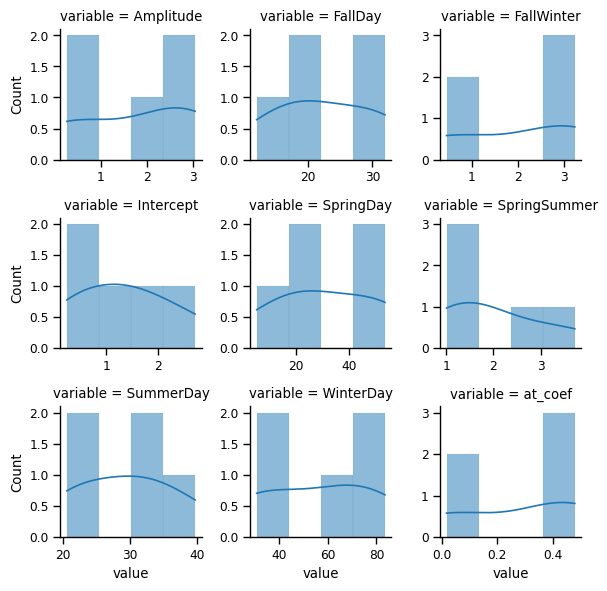

In [94]:
ewid = comb.assign(value=lambda x: x["value"].abs()).groupby(["id", "variable"])["value"].max().reset_index()
sns.displot(ewid, x="value", col="variable", col_wrap=3, height=2, kde=True, facet_kws={"sharex": False, "sharey": False},
           common_bins=False)